Upload images:


Saving glasses1.jpg to glasses1 (24).jpg
Saving glasses3.jpg to glasses3 (11).jpg
Saving glasses4.jfif to glasses4 (12).jfif
Saving glasses5.jpg to glasses5 (10).jpg
Saving modi.jfif to modi (1).jfif
Saving noglasses1.png to noglasses1 (2).png
Saving noglasses2.jfif to noglasses2 (2).jfif
Saving noglasses3.jpg to noglasses3 (2).jpg
Saving noglasses4.jpg to noglasses4 (2).jpg
Saving noglasses5.jfif to noglasses5 (2).jfif
Saving noglasses8.jpg to noglasses8 (3).jpg
Processing: glasses1 (24).jpg
Processing: glasses3 (11).jpg
Processing: glasses4 (12).jfif
Processing: glasses5 (10).jpg
Processing: modi (1).jfif
Processing: noglasses1 (2).png
Processing: noglasses2 (2).jfif
Processing: noglasses3 (2).jpg
Processing: noglasses4 (2).jpg
Processing: noglasses5 (2).jfif
Processing: noglasses8 (3).jpg


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

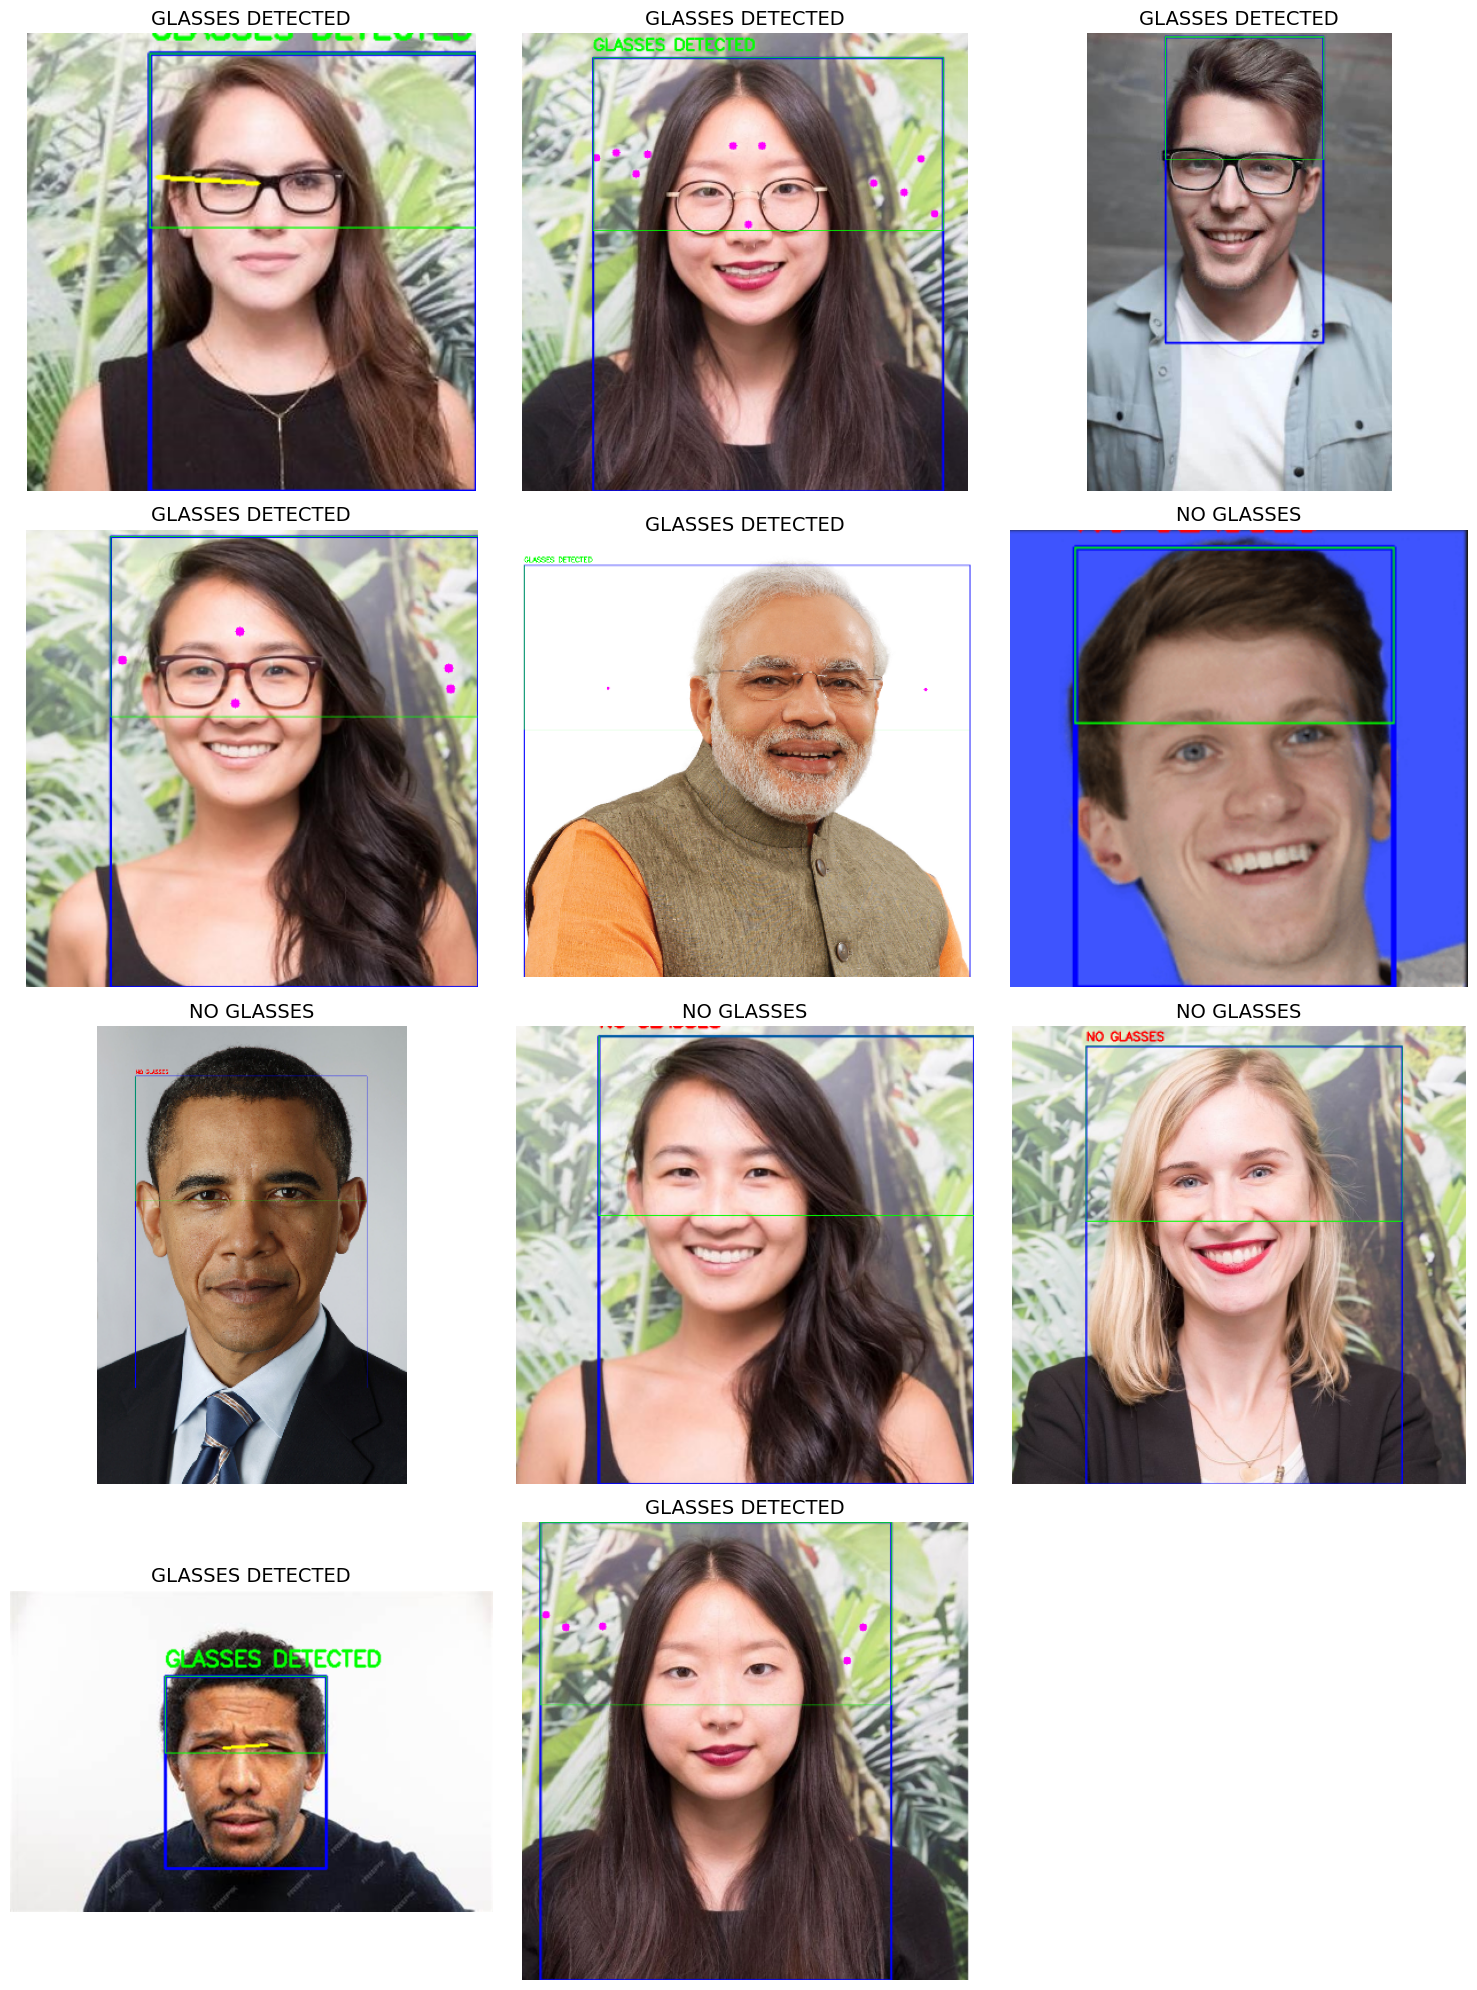

In [ ]:
#latest
import cv2
import numpy as np
from google.colab import files
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

def robust_glasses_detection(image_path):
    img = cv2.imread(image_path)
    if img is None:
        return None, "Error loading image"

    ycrcb = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    lower = np.array([0, 133, 77], dtype=np.uint8)
    upper = np.array([255, 173, 127], dtype=np.uint8)
    skin_mask = cv2.inRange(ycrcb, lower, upper)

    kernel = np.ones((5,5), np.uint8)
    skin_mask = cv2.morphologyEx(skin_mask, cv2.MORPH_CLOSE, kernel)
    skin_mask = cv2.morphologyEx(skin_mask, cv2.MORPH_OPEN, kernel, iterations=2)

    contours, _ = cv2.findContours(skin_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return img, "No Face Detected"

    face_contour = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(face_contour)

    roi_upper = cv2.cvtColor(img[y:y + int(h*0.4), x:x + w], cv2.COLOR_BGR2GRAY)
    roi_eyes = cv2.cvtColor(img[y + int(h*0.2):y + int(h*0.4), x:x + w], cv2.COLOR_BGR2GRAY)
    eye_region_color = img[y + int(h*0.2):y + int(h*0.4), x:x + w]

    frame_score = 0
    reflection_score = 0
    edge_score = 0

    edges = cv2.Canny(roi_upper, 70, 170)
    lines = cv2.HoughLinesP(edges, 1, np.pi/180, threshold=20, minLineLength=w//4, maxLineGap=5)

    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            angle = np.abs(np.arctan2(y2-y1, x2-x1) * 180/np.pi)
            if 175 < angle < 185 or 0 < angle < 5:
                frame_score += 1
                cv2.line(img, (x+x1, y+y1), (x+x2, y+y2), (0,255,255), 2)

    _, bright_spots = cv2.threshold(roi_eyes, 235, 255, cv2.THRESH_BINARY)
    bright_contours, _ = cv2.findContours(bright_spots, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    valid_reflections = []
    for cnt in bright_contours:
        if cv2.contourArea(cnt) > 15:
            M = cv2.moments(cnt)
            if M["m00"] != 0:
                cx = int(M["m10"]/M["m00"]) + x
                cy = int(M["m01"]/M["m00"]) + y + int(h*0.2)
                valid_reflections.append((cx, cy))

    if len(valid_reflections) >= 2:
        x_dist = abs(valid_reflections[0][0] - valid_reflections[1][0])
        y_dist = abs(valid_reflections[0][1] - valid_reflections[1][1])
        if x_dist > w/4 and y_dist < h/10:
            reflection_score = 2
            for (cx, cy) in valid_reflections:
                cv2.circle(img, (cx, cy), 5, (255,0,255), -1)

    edge_density = cv2.countNonZero(edges) / (roi_upper.size)
    edge_score = 1 if edge_density > 0.1 else 0

    hsv_eye = cv2.cvtColor(eye_region_color, cv2.COLOR_BGR2HSV)
    dark_mask = cv2.inRange(hsv_eye, np.array([0, 0, 0]), np.array([180, 255, 60]))
    contours, _ = cv2.findContours(dark_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    dark_boxes = 0
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if 100 < area < 3000:
            dark_boxes += 1
    if dark_boxes >= 2:
        frame_score += 1

    score = sum([
        frame_score > 0,
        reflection_score > 0,
        edge_score > 0
    ])
    glasses_detected = score >= 2

    cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 2)
    cv2.rectangle(img, (x, y), (x + w, y + int(h * 0.4)), (0, 255, 0), 1)

    result_text = "GLASSES DETECTED" if glasses_detected else "NO GLASSES"
    color = (0, 255, 0) if glasses_detected else (0, 0, 255)
    cv2.putText(img, result_text, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)

    # Resize for consistent display height
    height = 400
    scale = height / img.shape[0]
    width = int(img.shape[1] * scale)
    resized_img = cv2.resize(img, (width, height))

    return cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB), result_text  # RGB for matplotlib

# === Upload and Process Images ===
print("Upload images:")
uploaded = files.upload()

images = []
titles = []

for filename in uploaded.keys():
    print(f"Processing: {filename}")
    result_img, result_text = robust_glasses_detection(filename)
    images.append(result_img)
    titles.append(result_text)

# === Create PDF ===
pdf_path = "glasses_detection_results.pdf"
with PdfPages(pdf_path) as pdf:
    n = len(images)
    cols = 3
    rows = (n + cols - 1) // cols

    # Create a figure with subplots
    fig = plt.figure(figsize=(15, 5 * rows))

    for i in range(n):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(images[i])
        plt.title(titles[i], fontsize=14)
        plt.axis('off')

    plt.tight_layout()
    pdf.savefig(fig)  # Save the figure to PDF
    plt.close()

# Download the PDF
files.download(pdf_path)

# Also show the grid in the notebook
plt.figure(figsize=(15, 5 * rows))
for i in range(n):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(images[i])
    plt.title(titles[i], fontsize=14)
    plt.axis('off')
plt.tight_layout()
plt.show()